In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np
import os
from IPython.display import display

from LGBM_Pipelines import LGBM_base, LGBM_valves_pipeline, PCA_winsorizer_pipeline, LGBM_single_step_pipeline, LGBM_ablation_study_pipeline, benchmarks
from data_processing.process_data import process_data, get_single_df


## Data loading

In [2]:
datasets = process_data()

valve1_X =  datasets["valve1_X"]
valve1_y = datasets["valve1_y"]
valve2_X = datasets["valve2_X"]
valve2_y = datasets["valve2_y"]
other_anomaly_X = datasets["other_anomaly_X"]
other_anomaly_y = datasets["other_anomaly_y"]

In [3]:
X, y = get_single_df()

In [4]:
def test_train_split(df_X, df_y):
    size_train = int(df_X.shape[0]*0.8)
    size_test = df_X.shape[0] - size_train
    x_train = df_X[:size_train]
    y_train = df_y[:size_train].anomaly
    x_test = df_X[-size_test:]
    y_test = df_y[-size_test:].anomaly
    return x_train, y_train, x_test, y_test

In [5]:
x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1 = test_train_split(valve1_X, valve1_y)
x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2 = test_train_split(valve2_X, valve2_y)
x_train_other_anomaly, y_train_other_anomaly, x_test_other_anomaly, y_test_other_anomaly = test_train_split(other_anomaly_X, other_anomaly_y)

In [6]:
x_train, y_train, x_test, y_test = test_train_split(X, y)

In [7]:
model = lgb.LGBMClassifier()

In [8]:
steps = ["Add Rolling Stats", "Outlier capping", "Features Selection", "PCA"]

## Pipeline types

In [9]:
base = LGBM_base()
base

Pipeline(steps=[('Classifier', LGBMClassifier())])

In [10]:
PCA_winsorizer_pipeline(model)

Pipeline(steps=[('Outlier capping',
                 Winsorizer(capping_method='quantiles', fold=0.05,
                            tail='both')),
                ('PCA', PCA(n_components='mle', svd_solver='full')),
                ('Classifier', LGBMClassifier())])

In [11]:
LGBM_valves_pipeline(X)

Pipeline(steps=[('Add Rolling Stats',
                 FunctionTransformer(func=<function add_rolling_stats at 0x17be31a20>,
                                     kw_args={'columns': Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS'],
      dtype='object'),
                                              'time_diff': '1min'})),
                ('Outlier capping',
                 Winsorizer(capping_method='quantiles', fold=0.05,
                            tail='both')),
                ('Features Selection',
                 SelectBySingleFeaturePerformance(cv=2,
                                                  estimator=RandomForestClassifier(random_state=42))),
                ('Classifier', LGBMClassifier())])

### Combined dataset

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


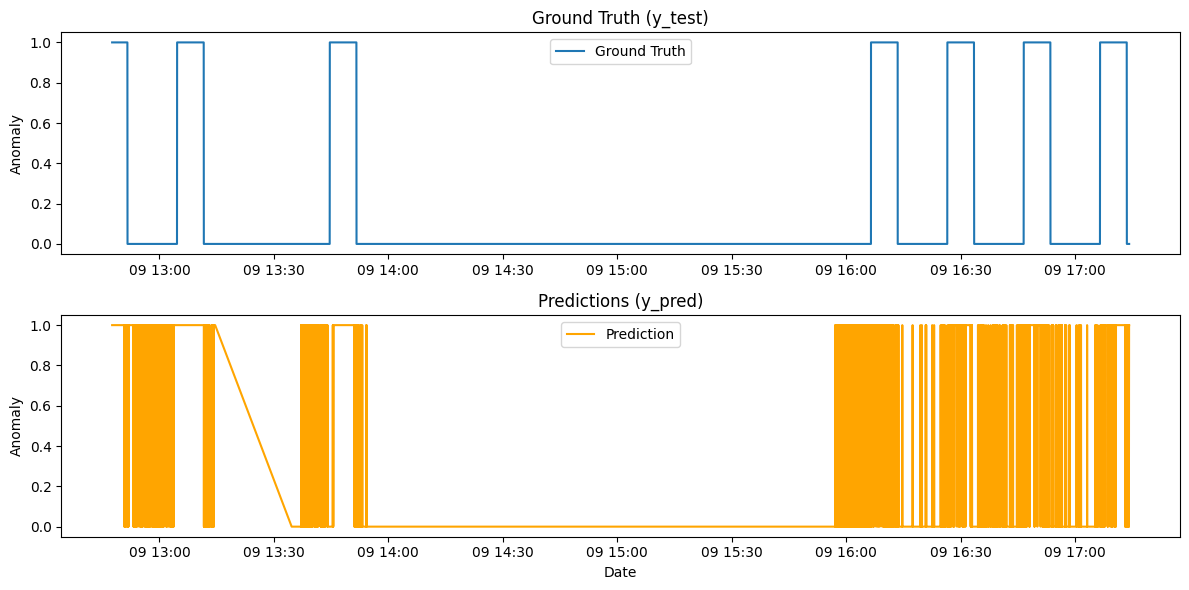

In [12]:
base_benchmark = benchmarks(x_train, y_train, x_test, y_test, LGBM_base())

[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


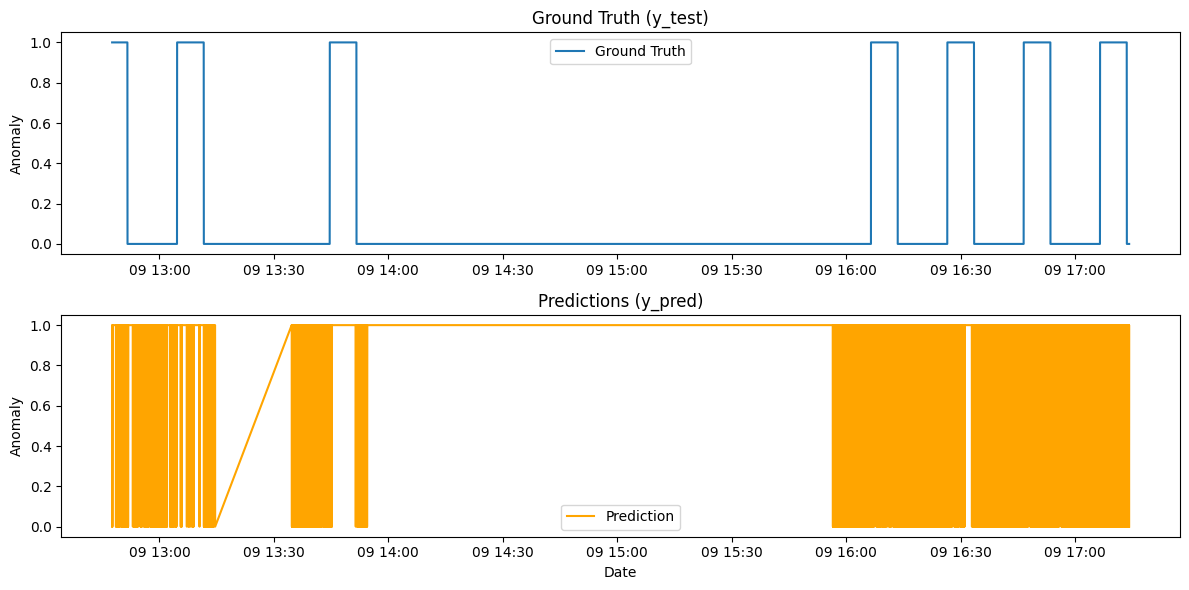

In [13]:
pipe_benchmark = benchmarks(x_train, y_train, x_test, y_test, PCA_winsorizer_pipeline(model))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8107
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


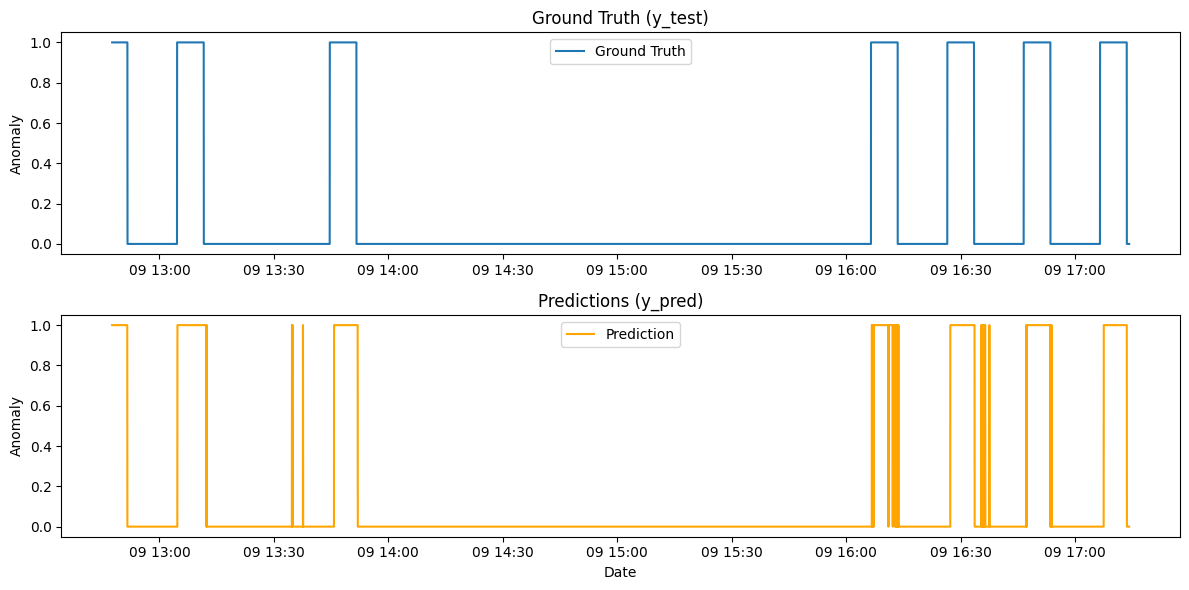

In [14]:
pipe_benchmark2 = benchmarks(x_train, y_train, x_test, y_test, LGBM_valves_pipeline(X))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1256
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


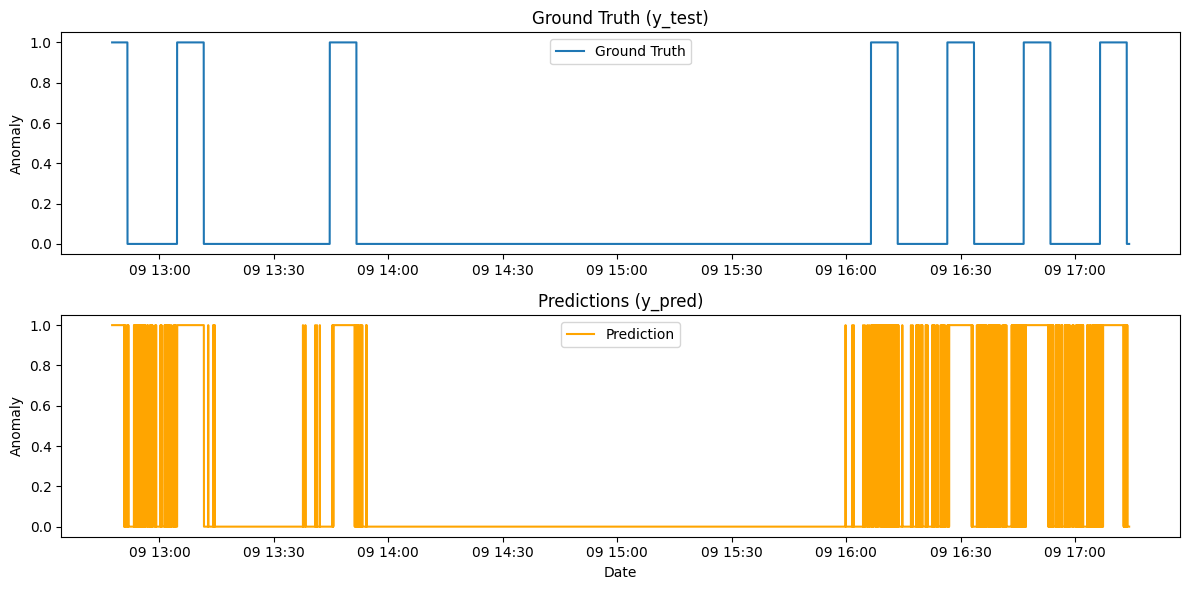

In [15]:
pipe_steps = ["Outlier capping", "Features Selection"]
ablation_study_pipeline1 =  benchmarks(x_train, y_train, x_test, y_test, LGBM_ablation_study_pipeline(X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7903
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


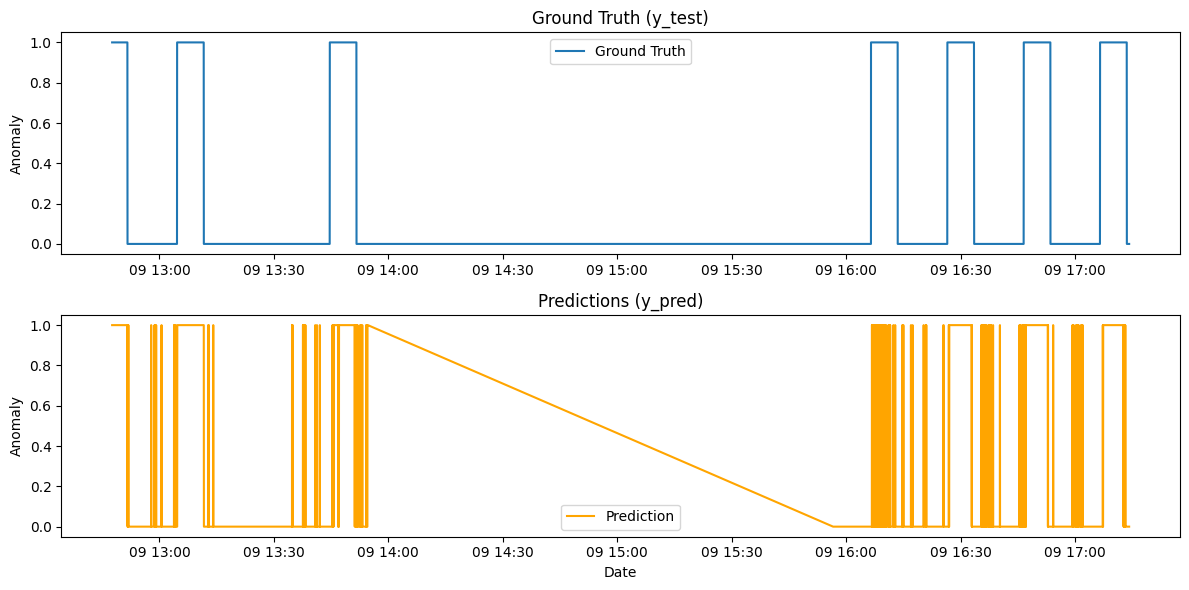

In [16]:
pipe_steps = ["Add Rolling Stats", "Features Selection"]
ablation_study_pipeline2 =  benchmarks(x_train, y_train, x_test, y_test, LGBM_ablation_study_pipeline(X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11932
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


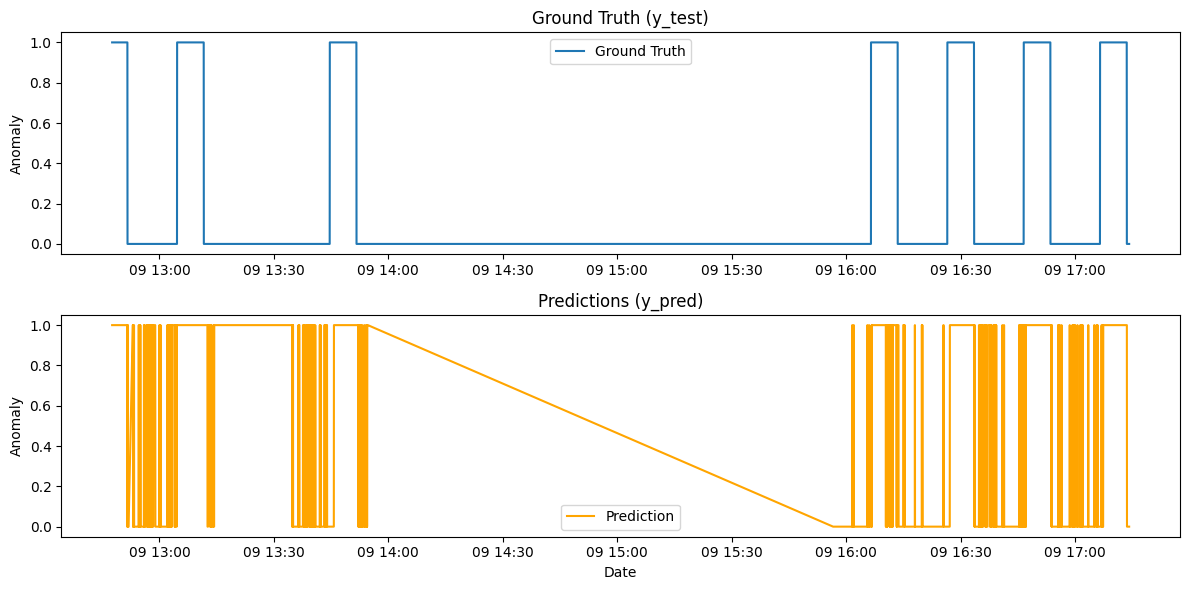

In [17]:
pipe_steps = ["Add Rolling Stats", "Outlier capping"]
ablation_study_pipeline3 =  benchmarks(x_train, y_train, x_test, y_test, LGBM_ablation_study_pipeline(X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11983
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


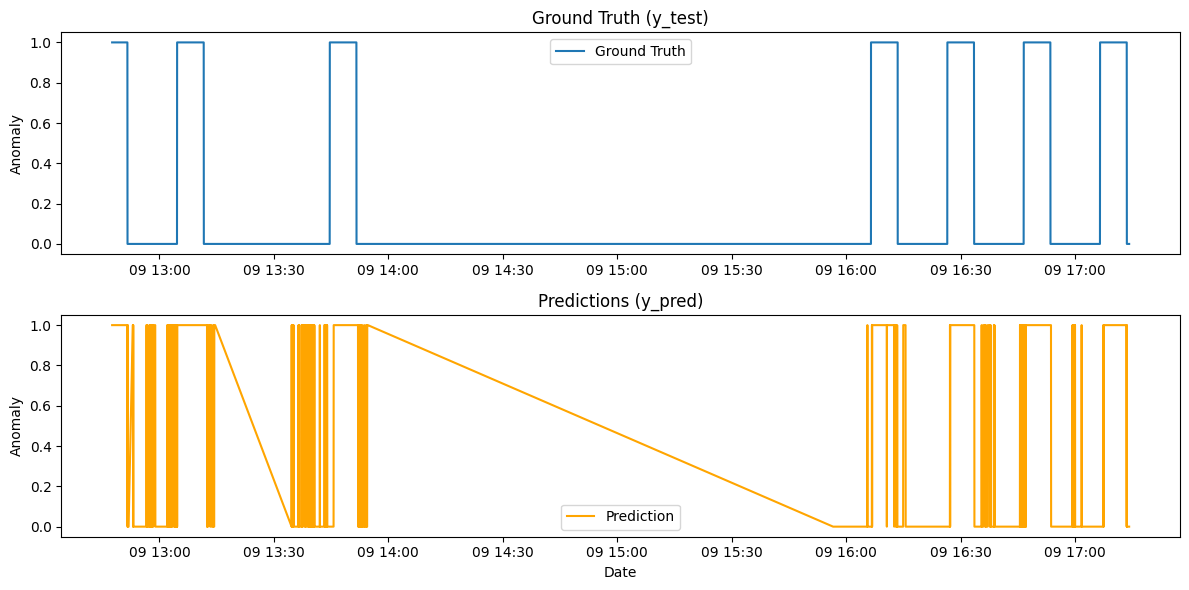

In [18]:
single_step_1 = benchmarks(x_train, y_train, x_test, y_test, LGBM_single_step_pipeline(X, steps[0]))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1766
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


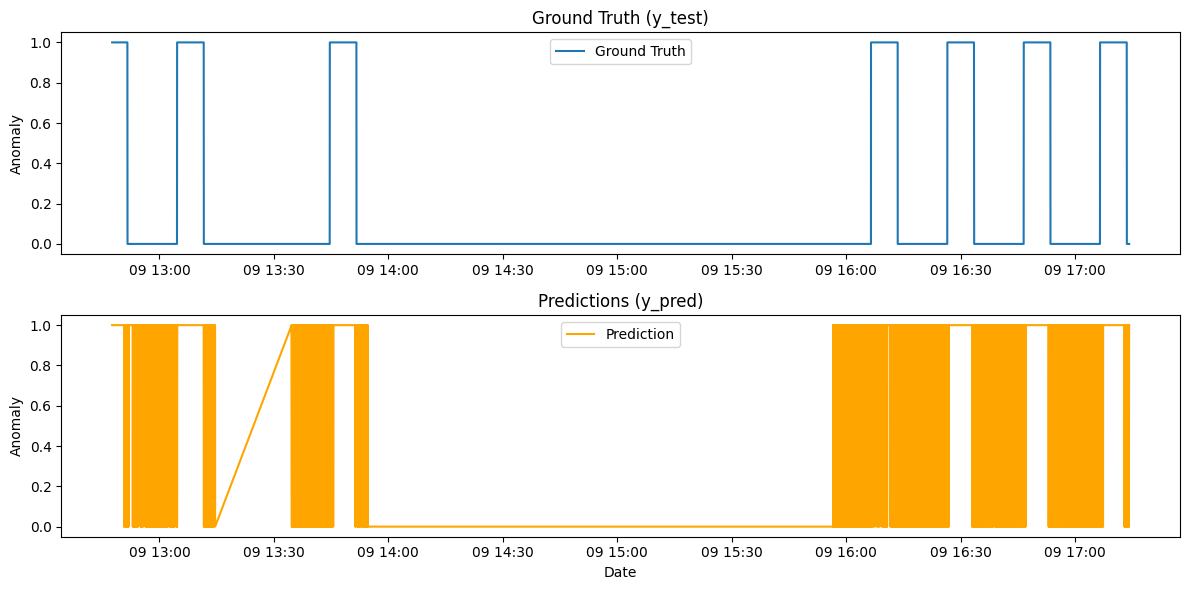

In [19]:
single_step_2 = benchmarks(x_train, y_train, x_test, y_test, LGBM_single_step_pipeline(X, steps[1]))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


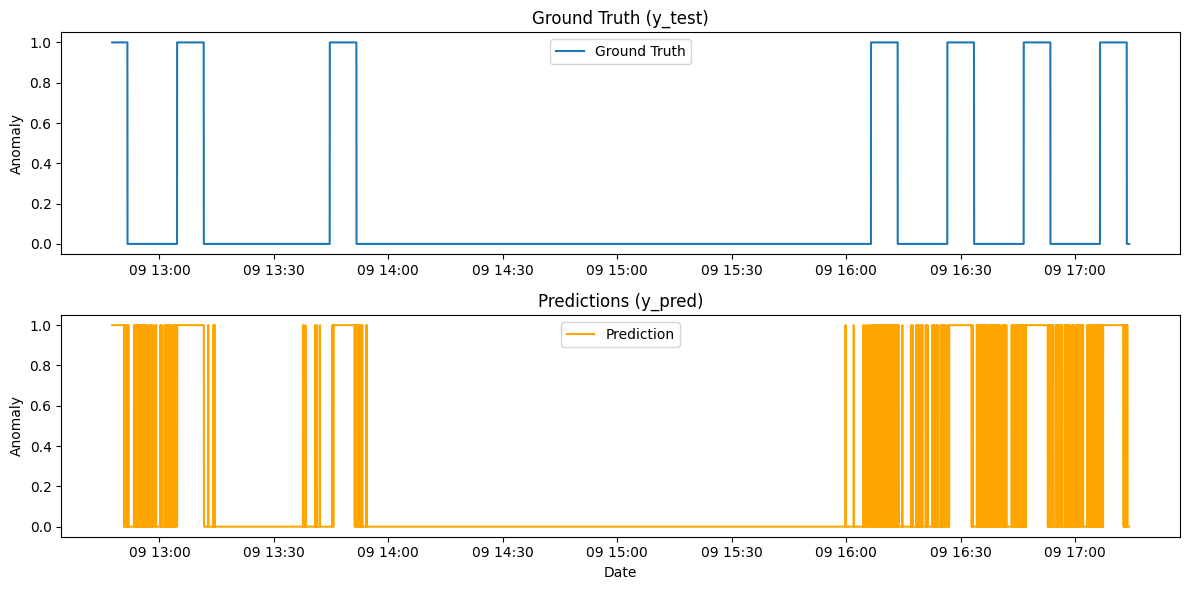

In [20]:
single_step_3 = benchmarks(x_train, y_train, x_test, y_test, LGBM_single_step_pipeline(X, steps[2]))

[LightGBM] [Info] Number of positive: 6745, number of negative: 21034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 27779, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242809 -> initscore=-1.137339
[LightGBM] [Info] Start training from score -1.137339


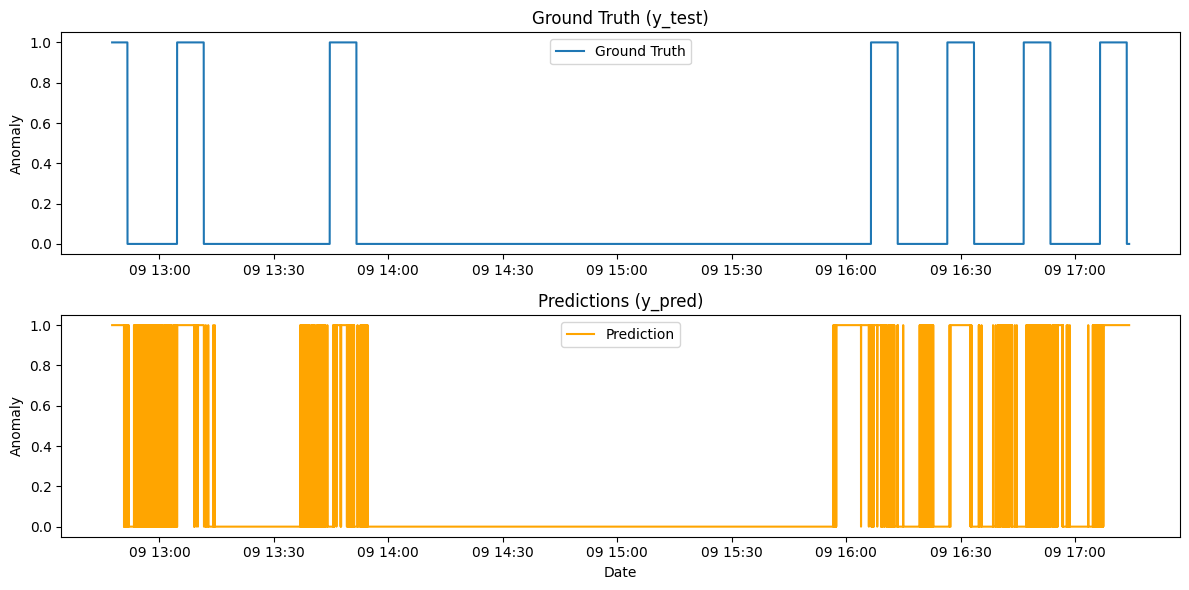

In [21]:
single_step_4 = benchmarks(x_train, y_train, x_test, y_test, LGBM_single_step_pipeline(X, steps[3]))

In [22]:
single_df_comparison = pd.concat([base_benchmark,
                                single_step_1, 
                                single_step_2, 
                                single_step_3, 
                                single_step_4,
                                ablation_study_pipeline1,
                                ablation_study_pipeline2,
                                ablation_study_pipeline3,
                                pipe_benchmark,
                                pipe_benchmark2, 
                                ], axis=0).round(3)

display(single_df_comparison)

,steps,FPR (FAR),FNR (MAR),ACC
0,[Classifier],0.309,0.182,0.738
0,"[Add Rolling Stats, Classifier]",0.129,0.083,0.888
0,"[Outlier capping, Classifier]",0.579,0.055,0.614
0,"[Features Selection, Classifier]",0.081,0.143,0.896
0,"[PCA, Classifier]",0.269,0.273,0.730
0,"[Outlier capping, Features Selection, Classifier]",0.084,0.136,0.897
0,"[Add Rolling Stats, Features Selection, Classi...",0.028,0.213,0.904
0,"[Add Rolling Stats, Outlier capping, Classifier]",0.170,0.072,0.866
0,"[Outlier capping, PCA, Classifier]",0.729,0.127,0.492
0,"[Add Rolling Stats, Outlier capping, Features ...",0.027,0.099,0.946


In [23]:
single_df_comparison.to_csv('single_df_comparison_LGBM.csv')

### Valve 1

In [24]:
print(f'{sum(y_train_valve1)} anomalies out of {y_train_valve1.shape[0]} entries in training')
print(f'{sum(y_test_valve1)} anomalies out of {y_test_valve1.shape[0]} entries in test')


5074.0 anomalies out of 14529 entries in training
1235.0 anomalies out of 3633 entries in test


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


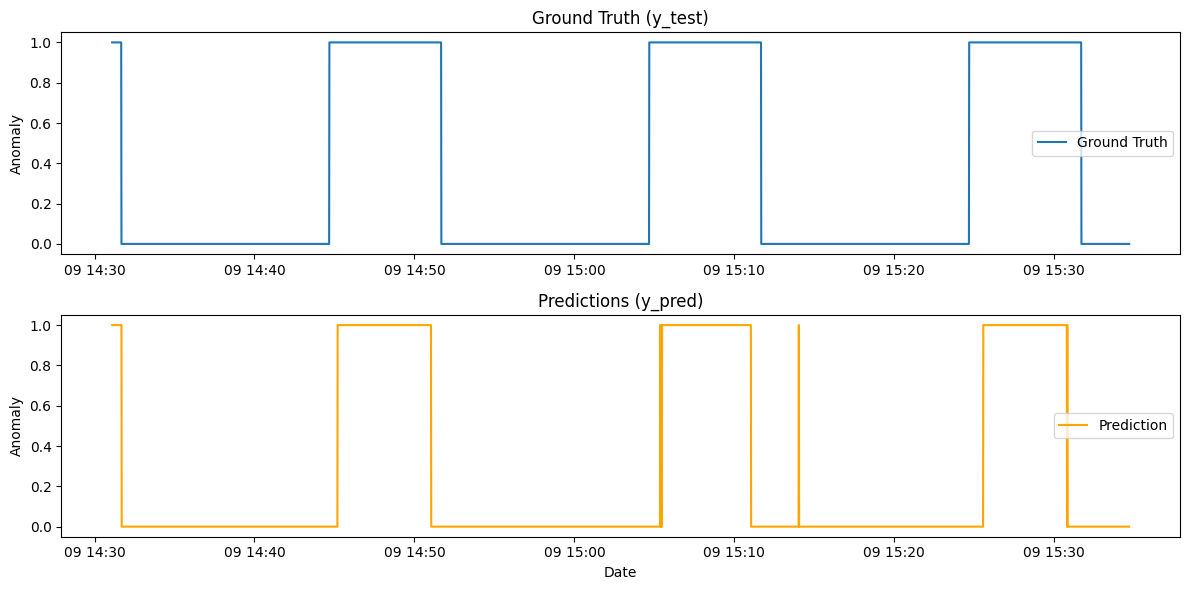

In [25]:
base_benchmark = benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_base())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3002
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


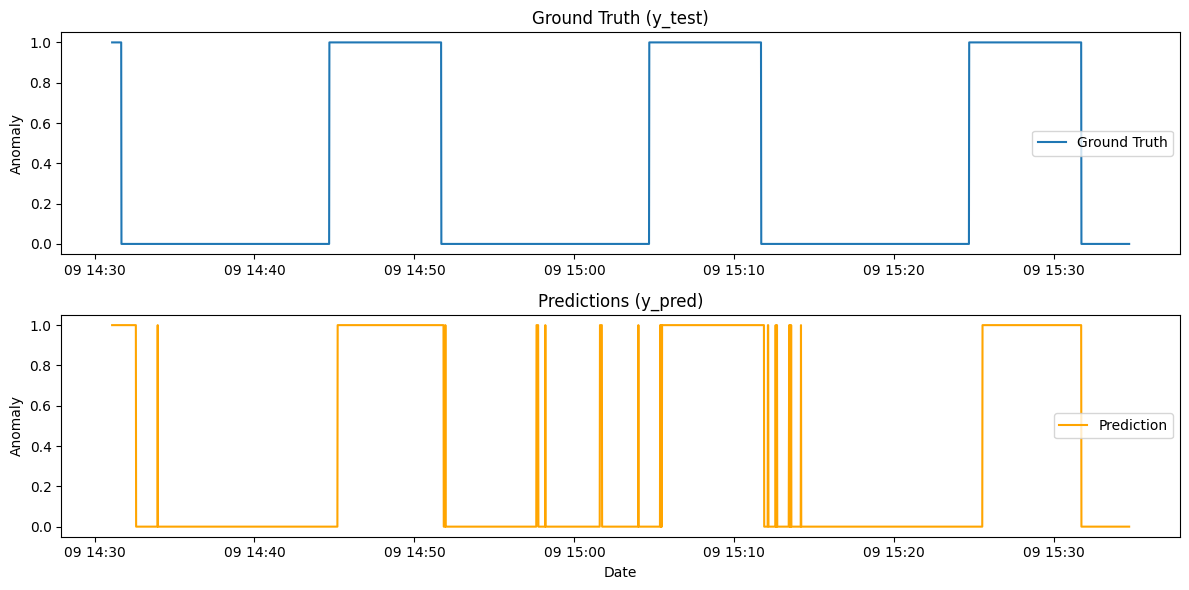

In [26]:
pipe_benchmark = benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_valves_pipeline(valve1_X))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


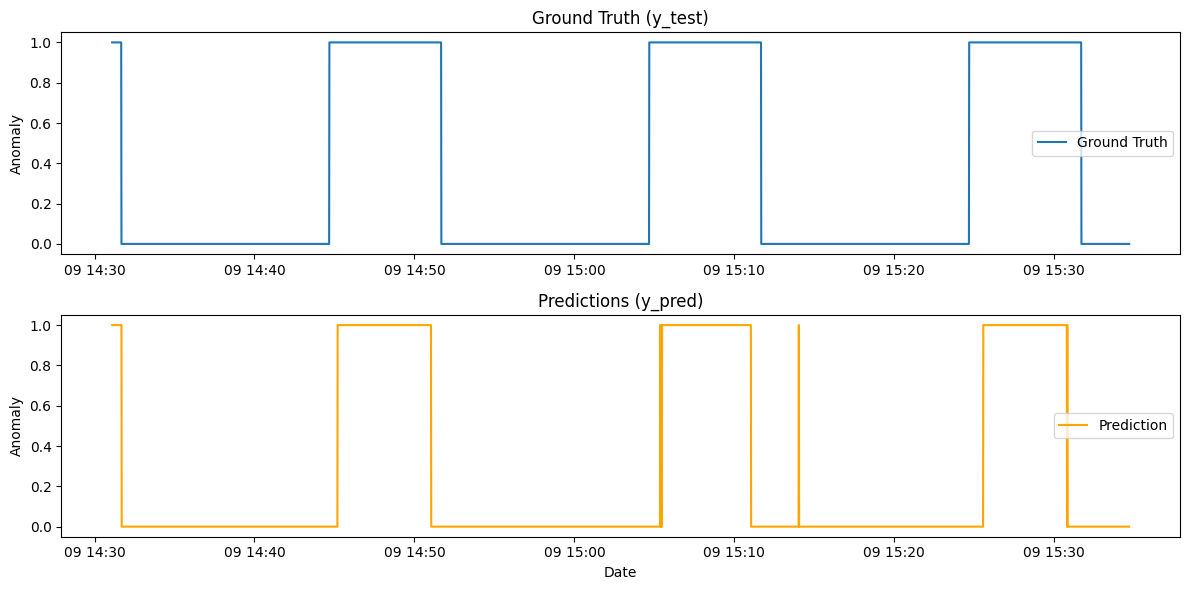

In [27]:
pipe_steps = ["Outlier capping", "Features Selection"]
ablation_study_pipeline1 =  benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_ablation_study_pipeline(valve1_X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3018
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


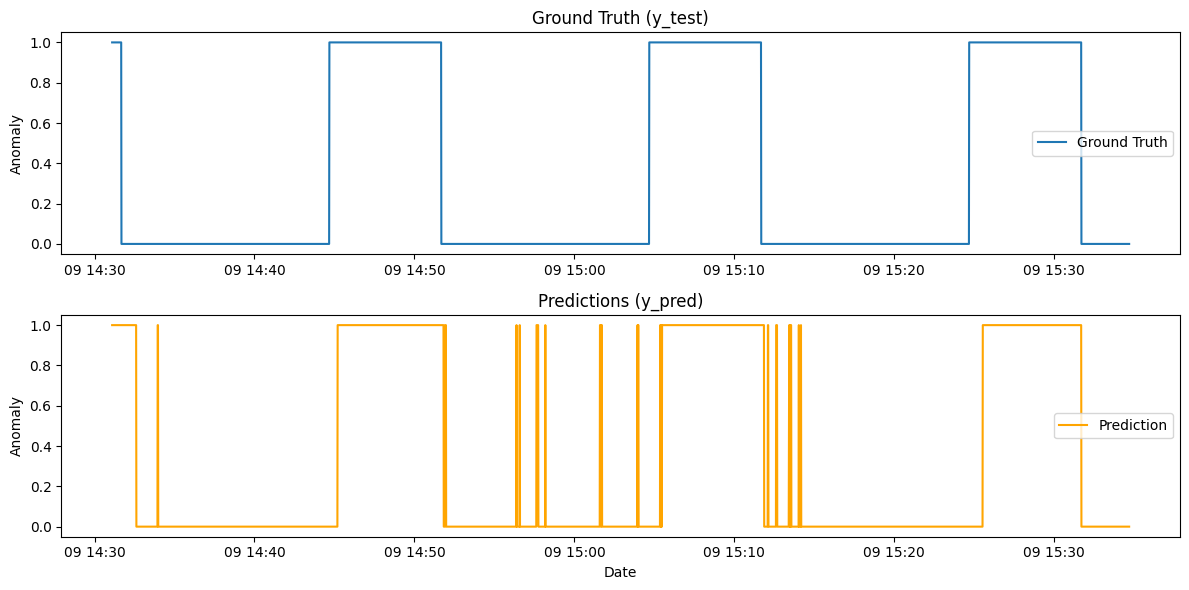

In [28]:
pipe_steps = ["Add Rolling Stats", "Features Selection"]
ablation_study_pipeline2 =  benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_ablation_study_pipeline(valve1_X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11858
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


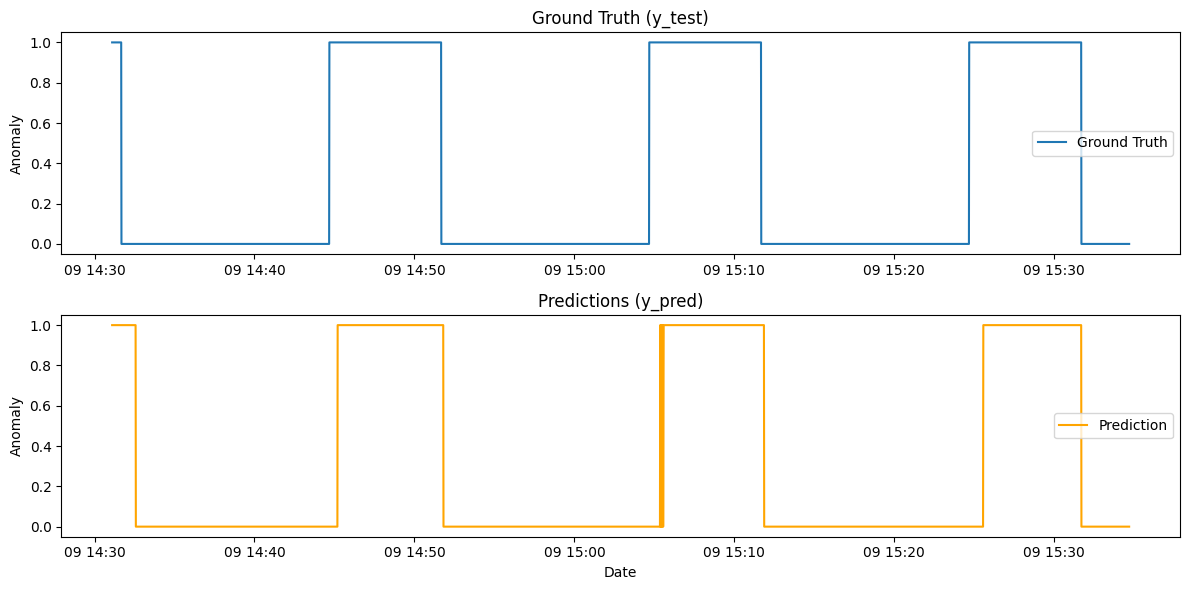

In [29]:
pipe_steps = ["Add Rolling Stats", "Outlier capping"]
ablation_study_pipeline3 =  benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_ablation_study_pipeline(valve1_X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11898
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


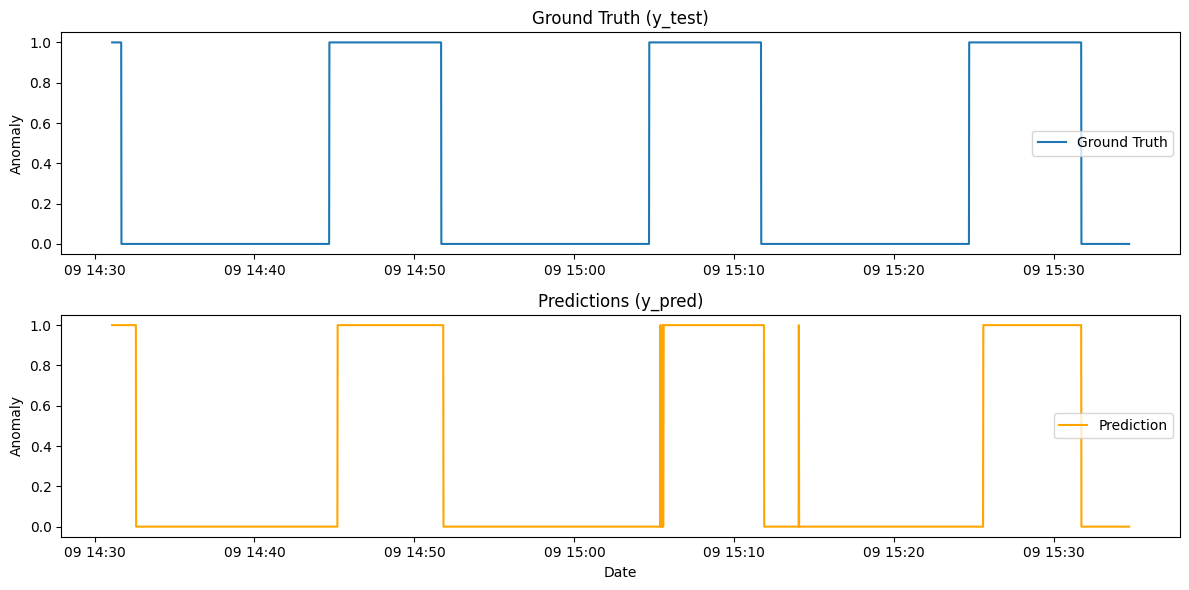

In [30]:
single_step_1 = benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_single_step_pipeline(valve1_X, steps[0]))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


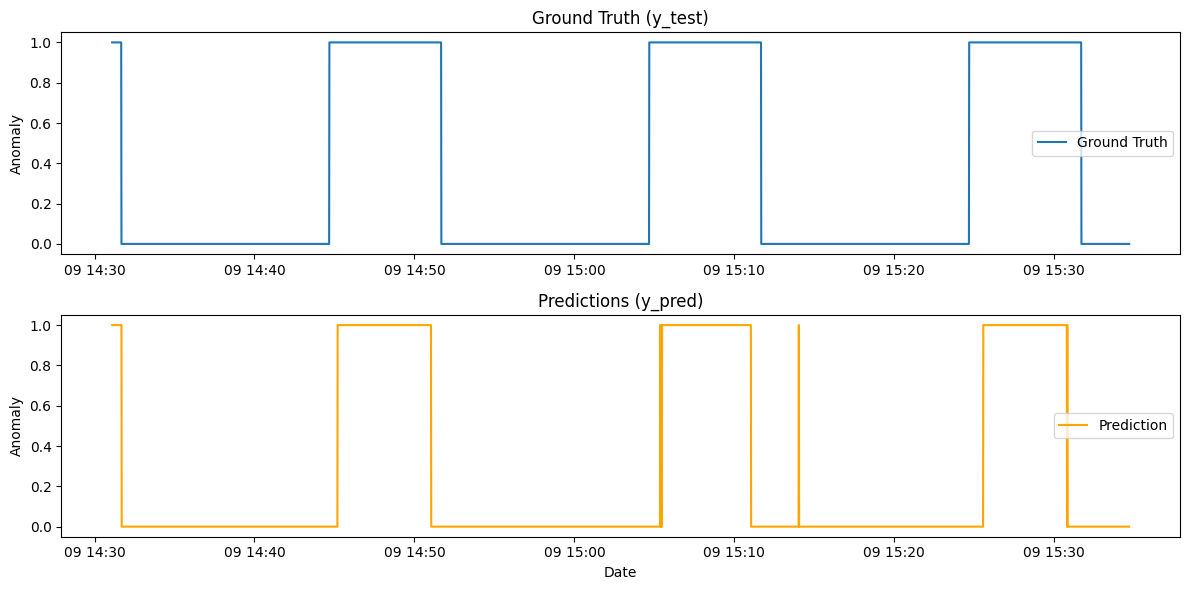

In [31]:
single_step_2 = benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_single_step_pipeline(valve1_X, steps[1]))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


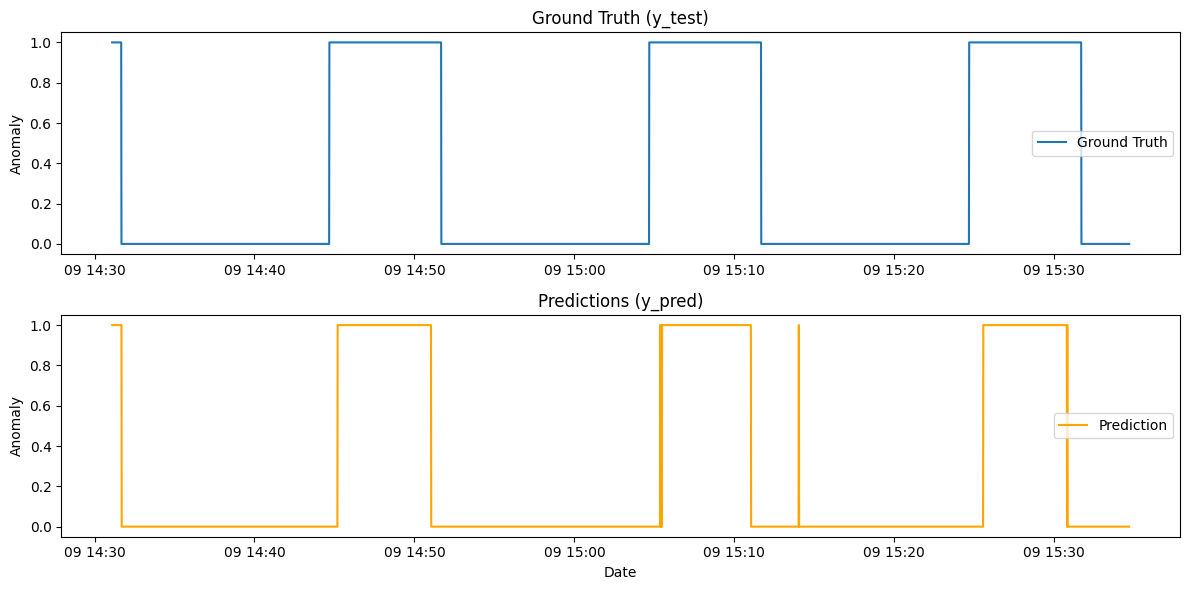

In [32]:
single_step_3 = benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_single_step_pipeline(valve1_X, steps[2]))

[LightGBM] [Info] Number of positive: 5074, number of negative: 9455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 14529, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349233 -> initscore=-0.622414
[LightGBM] [Info] Start training from score -0.622414


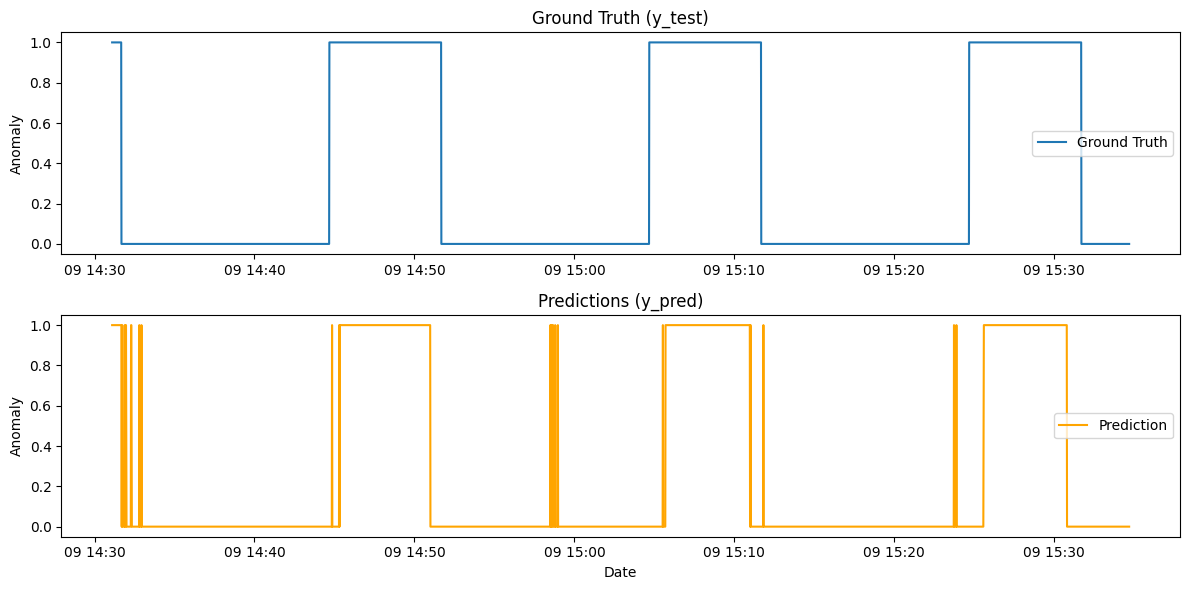

In [33]:
single_step_4 = benchmarks(x_train_valve1, y_train_valve1, x_test_valve1, y_test_valve1, LGBM_single_step_pipeline(valve1_X, steps[3]))

In [34]:
valve1_comparison = pd.concat([base_benchmark,
                            single_step_1, 
                            single_step_2, 
                            single_step_3, 
                            single_step_4,
                            ablation_study_pipeline1,
                            ablation_study_pipeline2,
                            ablation_study_pipeline3,
                            pipe_benchmark], axis=0).round(3)

display(valve1_comparison)

,steps,FPR (FAR),FNR (MAR),ACC
0,[Classifier],0.001,0.199,0.932
0,"[Add Rolling Stats, Classifier]",0.030,0.104,0.945
0,"[Outlier capping, Classifier]",0.001,0.199,0.932
0,"[Features Selection, Classifier]",0.001,0.199,0.932
0,"[PCA, Classifier]",0.007,0.221,0.920
0,"[Outlier capping, Features Selection, Classifier]",0.001,0.199,0.932
0,"[Add Rolling Stats, Features Selection, Classi...",0.046,0.098,0.936
0,"[Add Rolling Stats, Outlier capping, Classifier]",0.029,0.103,0.946
0,"[Add Rolling Stats, Outlier capping, Features ...",0.041,0.097,0.940


In [35]:
valve1_comparison.to_csv('valve1_comparison_LGBM.csv')

### Valve 2

In [36]:
print(f'{sum(y_train_valve2)} anomalies out of {y_train_valve2.shape[0]} entries in training')
print(f'{sum(y_test_valve2)} anomalies out of {y_test_valve2.shape[0]} entries in test')

1122.0 anomalies out of 3449 entries in training
395.0 anomalies out of 863 entries in test


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467


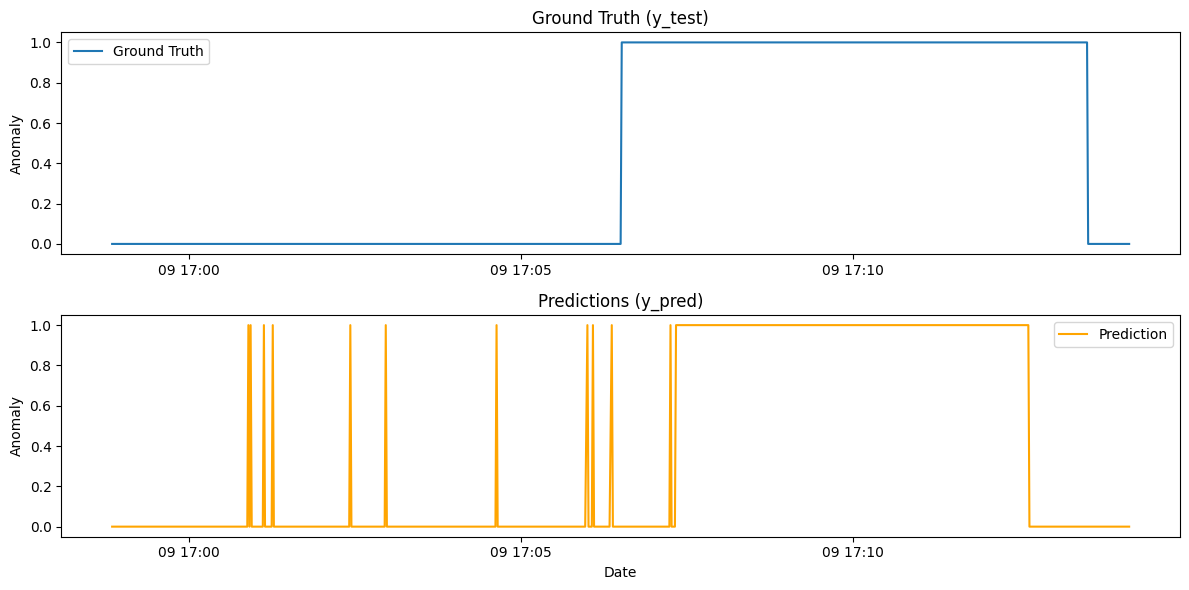

In [37]:
base_benchmark = benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_base())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


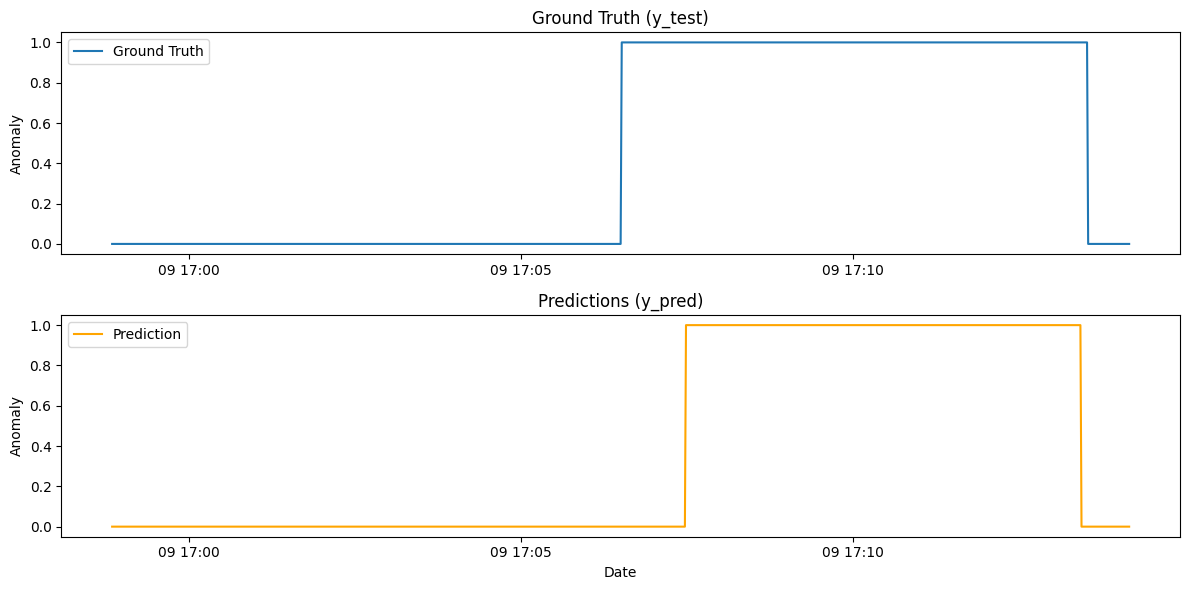

In [38]:
pipe_benchmark = benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_valves_pipeline(valve2_X))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11820
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


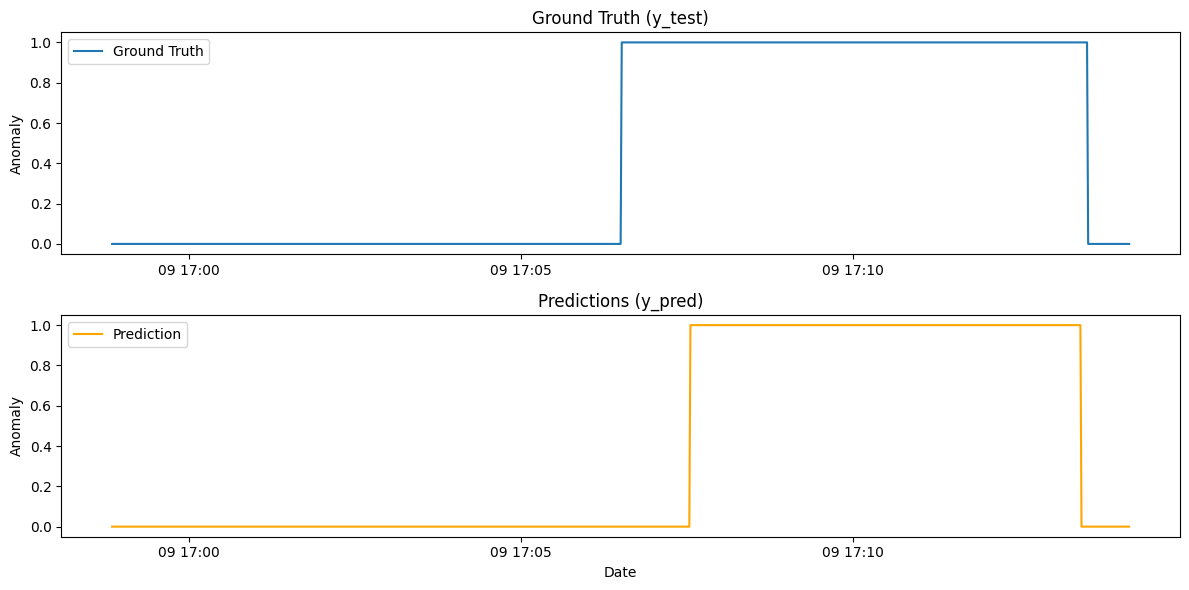

In [39]:
single_step_1 = benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_single_step_pipeline(valve2_X, steps[0]))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467


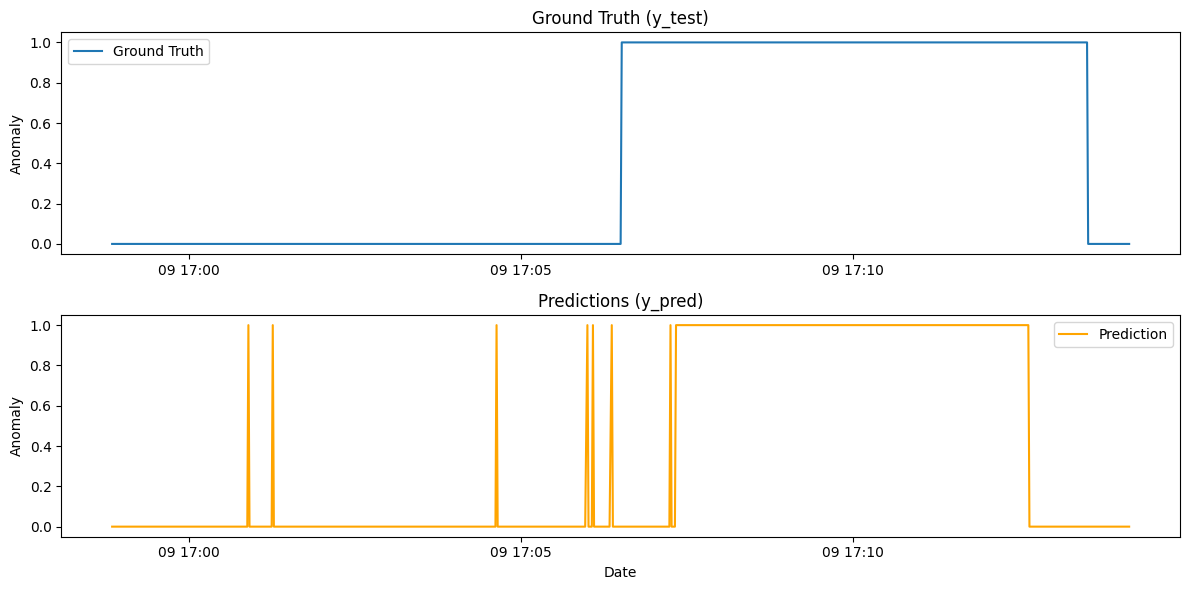

In [40]:
single_step_2 = benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_single_step_pipeline(valve2_X, steps[1]))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

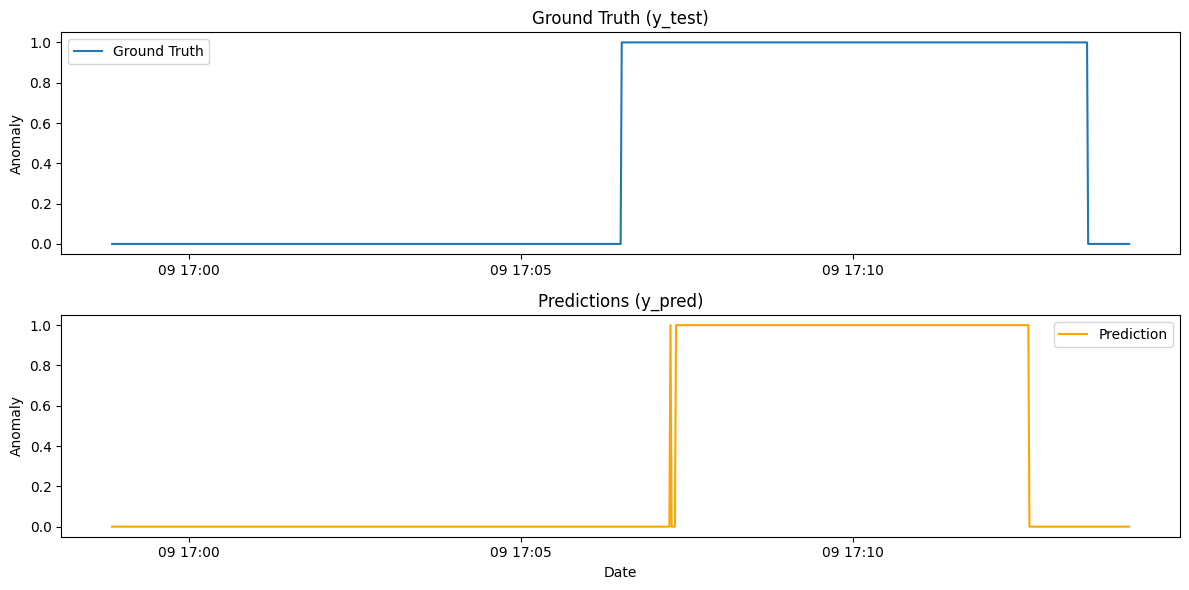

In [41]:
pipe_steps = ["Outlier capping", "Features Selection"]
ablation_study_pipeline1 =  benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_ablation_study_pipeline(valve2_X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


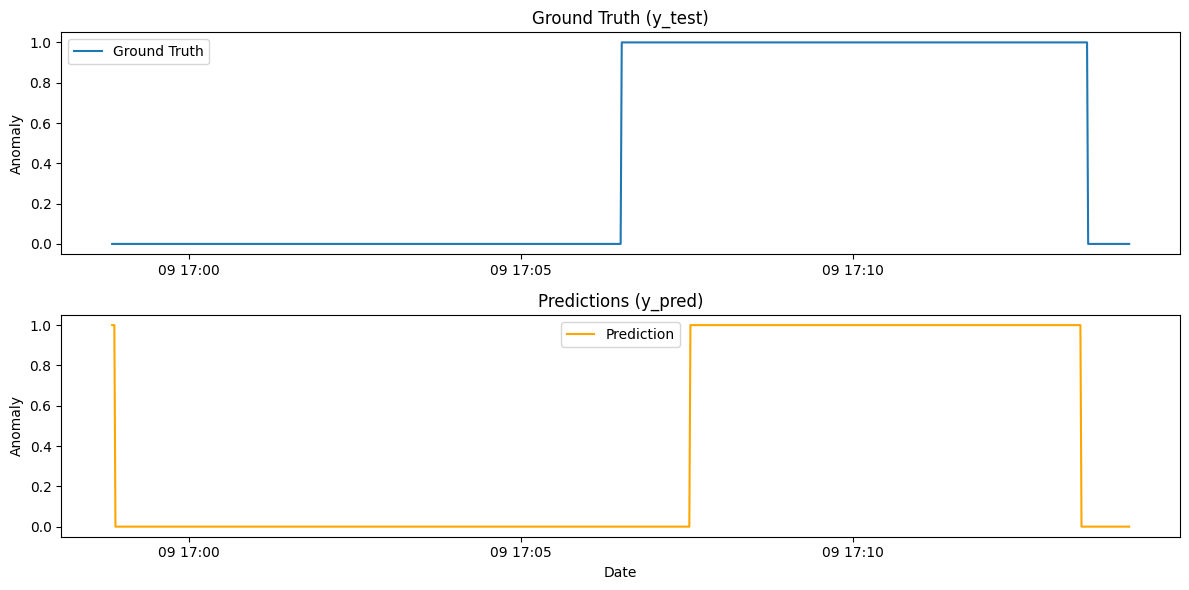

In [42]:
pipe_steps = ["Add Rolling Stats", "Features Selection"]
ablation_study_pipeline2 =  benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_ablation_study_pipeline(valve2_X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11734
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


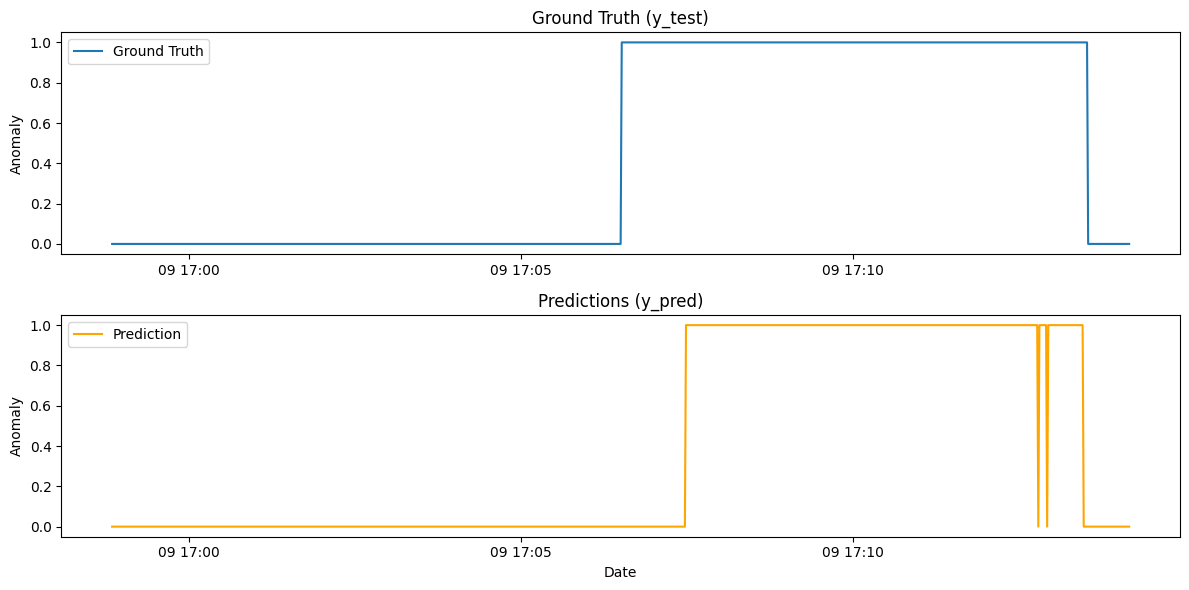

In [43]:
pipe_steps = ["Add Rolling Stats", "Outlier capping"]
ablation_study_pipeline3 =  benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_ablation_study_pipeline(valve2_X, pipe_steps))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

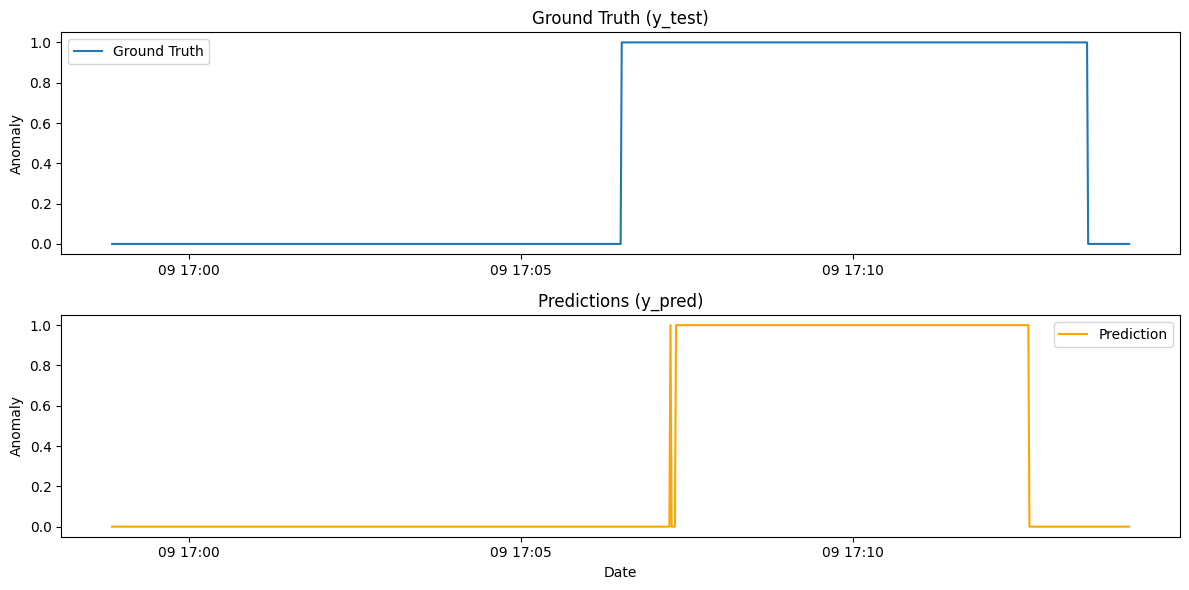

In [44]:
single_step_3 = benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_single_step_pipeline(valve2_X, steps[2]))

[LightGBM] [Info] Number of positive: 1122, number of negative: 2327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3449, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325312 -> initscore=-0.729467
[LightGBM] [Info] Start training from score -0.729467


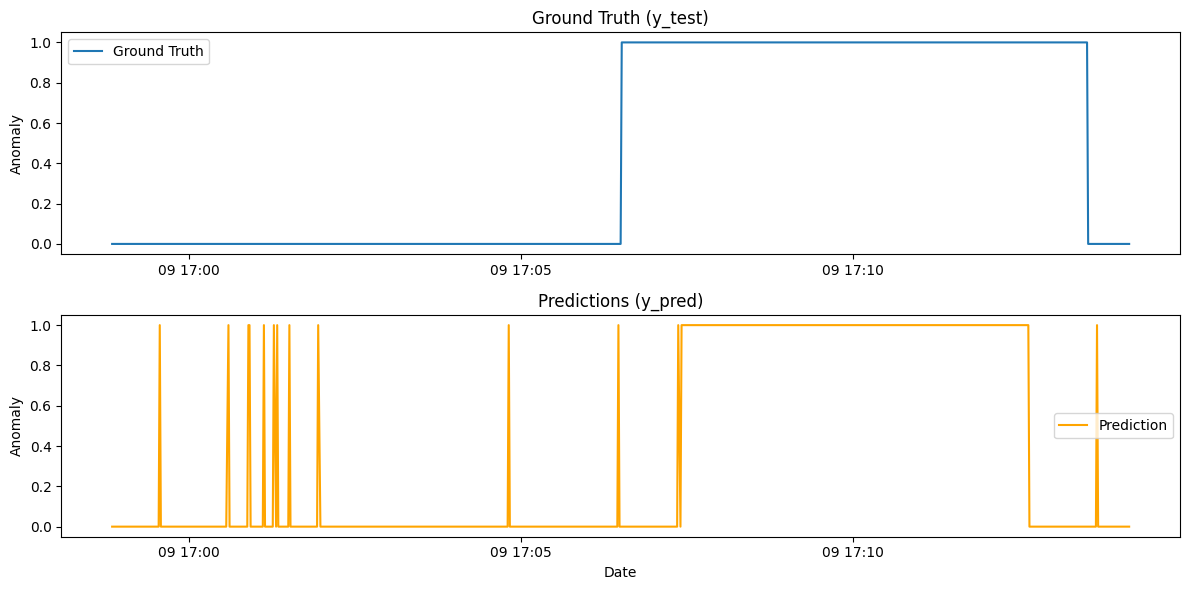

In [45]:
single_step_4 = benchmarks(x_train_valve2, y_train_valve2, x_test_valve2, y_test_valve2, LGBM_single_step_pipeline(valve2_X, steps[3]))

In [46]:
valve2_comparison = pd.concat([base_benchmark,
                            single_step_1, 
                            single_step_2, 
                            single_step_3, 
                            single_step_4,
                            ablation_study_pipeline1,
                            ablation_study_pipeline2,
                            ablation_study_pipeline3,
                            pipe_benchmark], axis=0).round(3)

display(valve2_comparison)

,steps,FPR (FAR),FNR (MAR),ACC
0,[Classifier],0.021,0.238,0.879
0,"[Add Rolling Stats, Classifier]",0.000,0.159,0.927
0,"[Outlier capping, Classifier]",0.013,0.238,0.884
0,"[Features Selection, Classifier]",0.000,0.238,0.891
0,"[PCA, Classifier]",0.026,0.248,0.873
0,"[Outlier capping, Features Selection, Classifier]",0.000,0.238,0.891
0,"[Add Rolling Stats, Features Selection, Classi...",0.006,0.159,0.924
0,"[Add Rolling Stats, Outlier capping, Classifier]",0.000,0.149,0.932
0,"[Add Rolling Stats, Outlier capping, Features ...",0.000,0.149,0.932


In [47]:
valve2_comparison.to_csv('valve2_comparison_LGBM.csv')

### Other Anomalies

In [48]:
print(f'{sum(y_train_other_anomaly)} anomalies out of {y_train_other_anomaly.shape[0]} entries in training')
print(f'{sum(y_test_other_anomaly)} anomalies out of {y_test_other_anomaly.shape[0]} entries in test')

4046.0 anomalies out of 11836 entries in training
1369.0 anomalies out of 2959 entries in test


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4046, number of negative: 7790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1767
[LightGBM] [Info] Number of data points in the train set: 11836, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341838 -> initscore=-0.655112
[LightGBM] [Info] Start training from score -0.655112


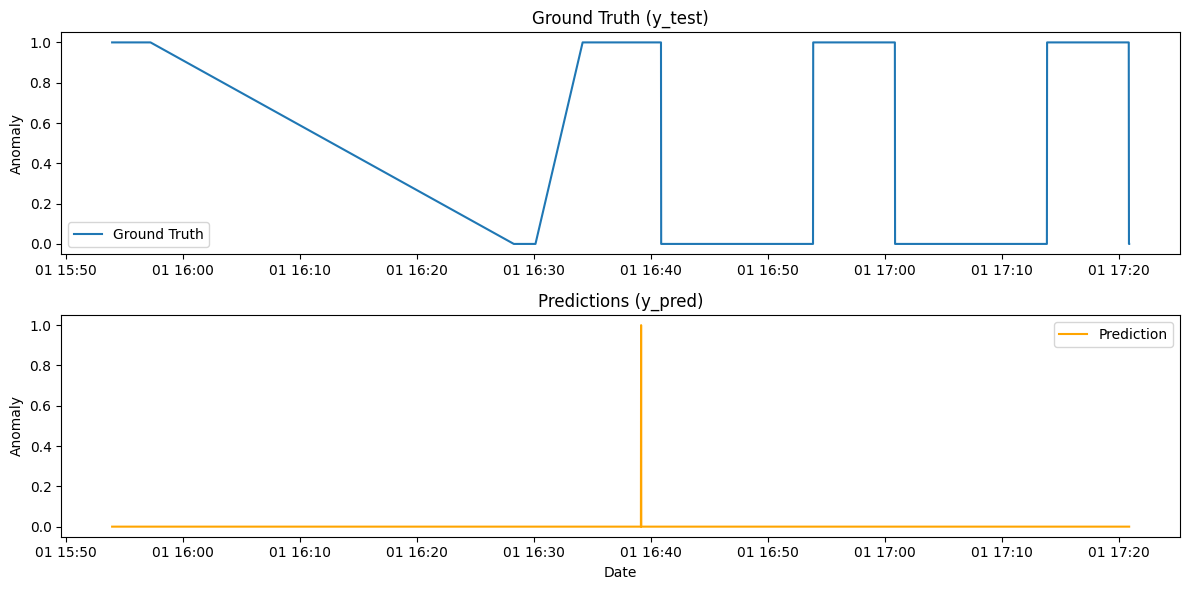

In [49]:
base_benchmark = benchmarks(x_train_other_anomaly, y_train_other_anomaly, x_test_other_anomaly, y_test_other_anomaly, LGBM_base())

[LightGBM] [Info] Number of positive: 4046, number of negative: 7790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 11836, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341838 -> initscore=-0.655112
[LightGBM] [Info] Start training from score -0.655112


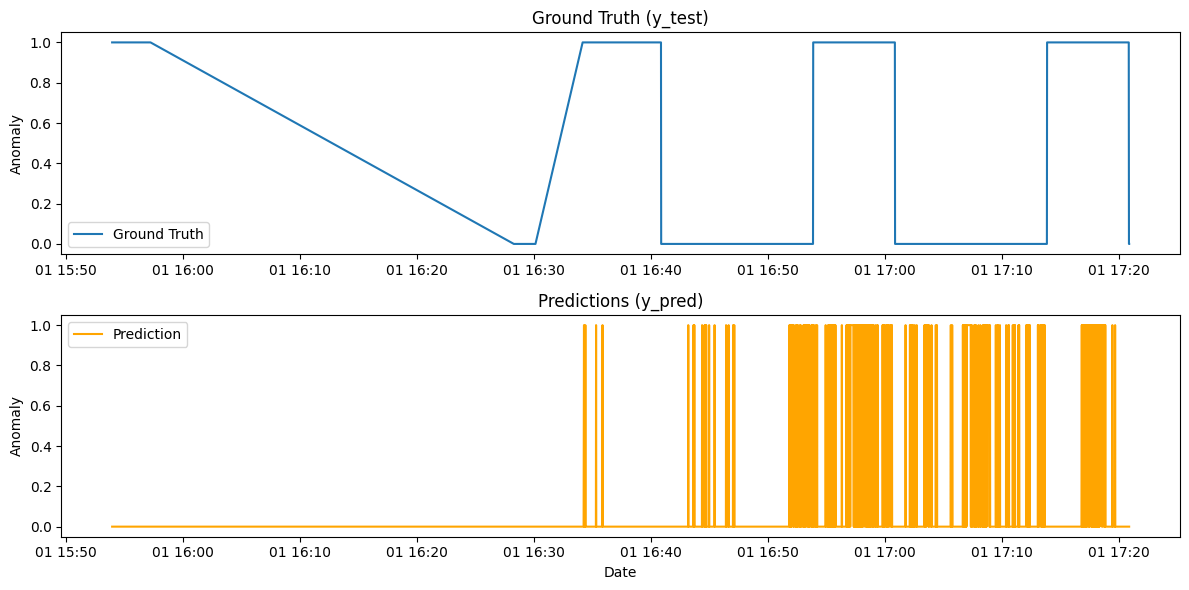

In [50]:
pipe_benchmark = benchmarks(x_train_other_anomaly, y_train_other_anomaly, x_test_other_anomaly, y_test_other_anomaly, PCA_winsorizer_pipeline(model))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4046, number of negative: 7790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1754
[LightGBM] [Info] Number of data points in the train set: 11836, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341838 -> initscore=-0.655112
[LightGBM] [Info] Start training from score -0.655112


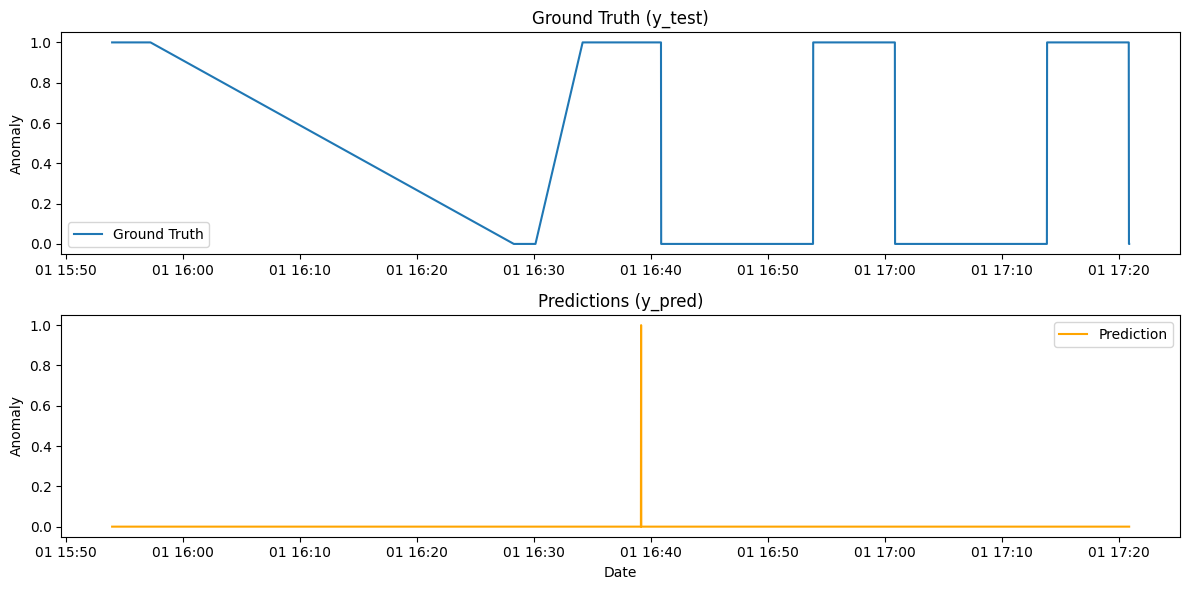

In [51]:
single_step_1 = benchmarks(x_train_other_anomaly, y_train_other_anomaly, x_test_other_anomaly, y_test_other_anomaly, LGBM_single_step_pipeline(other_anomaly_X, steps[1]))

[LightGBM] [Info] Number of positive: 4046, number of negative: 7790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 11836, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341838 -> initscore=-0.655112
[LightGBM] [Info] Start training from score -0.655112


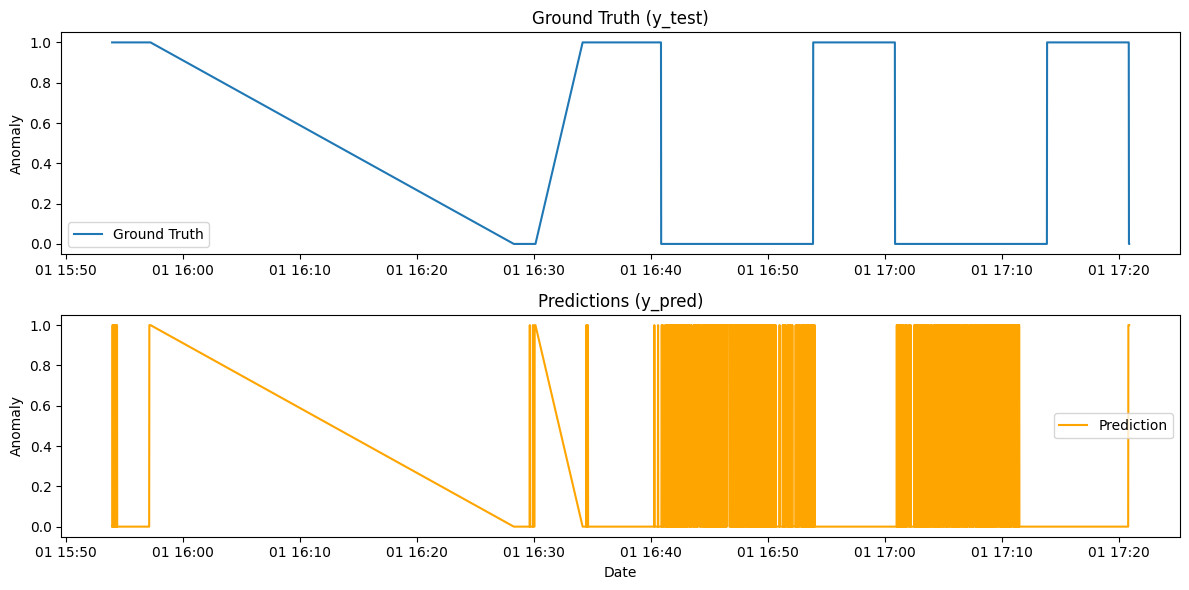

In [52]:
single_step_2 = benchmarks(x_train_other_anomaly, y_train_other_anomaly, x_test_other_anomaly, y_test_other_anomaly, LGBM_single_step_pipeline(other_anomaly_X, steps[3]))

In [53]:
other_anomalies_comparison = pd.concat([base_benchmark,
                                    single_step_1, 
                                    single_step_2, 
                                    pipe_benchmark], axis=0).round(3)

display(other_anomalies_comparison)

,steps,FPR (FAR),FNR (MAR),ACC
0,[Classifier],0.000,0.999,0.538
0,"[Outlier capping, Classifier]",0.000,0.999,0.538
0,"[PCA, Classifier]",0.363,0.980,0.352
0,"[Outlier capping, PCA, Classifier]",0.119,0.853,0.541


In [54]:
other_anomalies_comparison.to_csv('other_anomalies_comparison_LGBM.csv')